# Model Training for Product Recommendation System

## Overview
This notebook trains and saves all the machine learning models required for the Product Recommendation System. The trained models will be loaded by the Streamlit web application.

### Three Recommendation Approaches:
1. **Part I:** Popularity-Based Recommendation (for new customers)
2. **Part II:** Collaborative Filtering using SVD (for returning customers)
3. **Part III:** Content-Based Filtering using Text Clustering (for new businesses)

### Workflow:
1. Load and preprocess datasets
2. Train each recommendation model
3. Save models to `models/` directory
4. These saved models are loaded by `app.py` (Streamlit app)

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pickle
import os

# Set plot style
plt.style.use('ggplot')
print("Libraries imported successfully!")

Libraries imported successfully!


## Create Models Directory

In [2]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)
print("Models directory ready!")

Models directory ready!


---
# Part I: Popularity-Based Recommendation System

## Business Context
When a **new customer** visits the e-commerce website for the first time without any purchase history, we recommend the **most popular products** sold on the website.

## Approach
- Count the number of ratings for each product
- Products with more ratings are considered more popular
- Also calculate average rating for quality indication

## Dataset
Amazon Product Review Dataset (Beauty Category)

### Load Amazon Ratings Data

In [3]:
# Load the Amazon Beauty ratings dataset
amazon_ratings = pd.read_csv('ratings_Beauty.csv')
amazon_ratings = amazon_ratings.dropna()

print(f"Dataset Shape: {amazon_ratings.shape}")
print(f"Total Ratings: {len(amazon_ratings):,}")
print(f"\nColumns: {list(amazon_ratings.columns)}")
amazon_ratings.head()

Dataset Shape: (2023070, 4)
Total Ratings: 2,023,070

Columns: ['UserId', 'ProductId', 'Rating', 'Timestamp']


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


### Calculate Product Popularity

In [4]:
# Calculate popularity (number of ratings per product)
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
popular_products = popular_products.rename(columns={'Rating': 'RatingCount'})

# Calculate average rating for each product
avg_ratings = amazon_ratings.groupby('ProductId')['Rating'].mean()
popular_products['AvgRating'] = avg_ratings

# Sort by popularity (most ratings first)
popular_products = popular_products.sort_values('RatingCount', ascending=False)

print(f"Total Unique Products: {len(popular_products):,}")
print("\nTop 10 Most Popular Products:")
popular_products.head(10)

Total Unique Products: 249,274

Top 10 Most Popular Products:


,RatingCount,AvgRating
ProductId,,
B001MA0QY2,7533,4.321386
B0009V1YR8,2869,3.568839
B0043OYFKU,2477,4.310456
B0000YUXI0,2143,4.405040
B003V265QW,2088,4.365421
B000ZMBSPE,2041,4.422342
B003BQ6QXK,1918,4.625652
B004OHQR1Q,1885,4.465782
B00121UVU0,1838,4.538085


### Visualize Top Popular Products

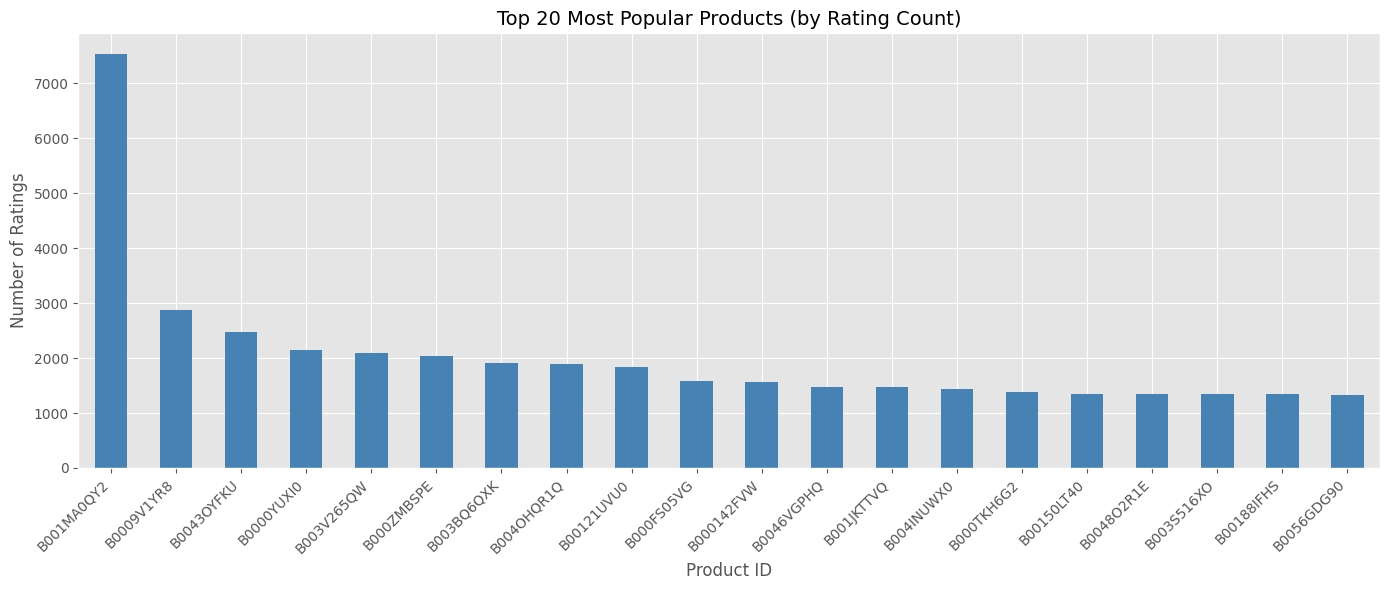

In [5]:
# Visualize top 20 popular products
plt.figure(figsize=(14, 6))
popular_products.head(20)['RatingCount'].plot(kind='bar', color='steelblue')
plt.title('Top 20 Most Popular Products (by Rating Count)', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Save Popularity Model

In [6]:
# Save popularity data
popular_products.to_pickle('models/popular_products.pkl')
print(f" Saved popularity model with {len(popular_products):,} products")
print(f"   File: models/popular_products.pkl")

 Saved popularity model with 249,274 products
   File: models/popular_products.pkl


---
# Part II: Model-Based Collaborative Filtering

## Business Context
Once a customer makes a purchase, we recommend products based on:
- Their purchase history
- Ratings provided by other users who bought similar items

## Approach: Truncated SVD (Singular Value Decomposition)
1. Create a **Utility Matrix** (User-Item rating matrix)
2. Apply **Truncated SVD** for dimensionality reduction
3. Compute **Correlation Matrix** between products
4. Recommend products with high correlation to purchased items

## Why SVD?
- Handles sparse matrices efficiently
- Reduces dimensionality while preserving patterns
- Captures latent factors in user preferences

### Prepare Data Subset

In [7]:
# Use a subset for memory efficiency
SAMPLE_SIZE = 50000
amazon_ratings_subset = amazon_ratings.head(SAMPLE_SIZE)

print(f"Using {len(amazon_ratings_subset):,} ratings for collaborative filtering")
print(f"Unique Users: {amazon_ratings_subset['UserId'].nunique():,}")
print(f"Unique Products: {amazon_ratings_subset['ProductId'].nunique():,}")

Using 50,000 ratings for collaborative filtering
Unique Users: 47,017
Unique Products: 2,581


### Create Utility Matrix

In [8]:
# Create User-Item utility matrix
ratings_utility_matrix = amazon_ratings_subset.pivot_table(
    values='Rating', 
    index='UserId', 
    columns='ProductId', 
    fill_value=0
)

print(f"Utility Matrix Shape: {ratings_utility_matrix.shape}")
print(f"  - Rows (Users): {ratings_utility_matrix.shape[0]:,}")
print(f"  - Columns (Products): {ratings_utility_matrix.shape[1]:,}")

# Show sparsity
sparsity = 1 - (ratings_utility_matrix.values.nonzero()[0].size / 
               (ratings_utility_matrix.shape[0] * ratings_utility_matrix.shape[1]))
print(f"\nMatrix Sparsity: {sparsity*100:.2f}%")

ratings_utility_matrix.head()

Utility Matrix Shape: (47017, 2581)
  - Rows (Users): 47,017
  - Columns (Products): 2,581

Matrix Sparsity: 99.96%


ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B00013TQRE,B00013UHBS,B00013V0A0,B00013V0AU,B00013YYS0,B00013YZ7U,B00013YZCA,B00013YZRU,B00013YZS4,B00013Z0CE
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00473363TJ8YSZ3YAGG9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01437583CZ7V02UKZQ5S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01456542S5QPYUEGJXR8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01907982I6OHXDYN5HD6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply Truncated SVD

In [9]:
# Transpose matrix for product-based recommendations
X = ratings_utility_matrix.T
print(f"Transposed Matrix Shape: {X.shape}")

# Determine number of components
n_components = min(15, X.shape[0] - 1, X.shape[1] - 1)
print(f"\nApplying SVD with {n_components} components...")

# Apply Truncated SVD
SVD = TruncatedSVD(n_components=n_components, random_state=42)
decomposed_matrix = SVD.fit_transform(X)

print(f"Decomposed Matrix Shape: {decomposed_matrix.shape}")
print(f"Explained Variance Ratio: {SVD.explained_variance_ratio_.sum()*100:.2f}%")

Transposed Matrix Shape: (2581, 47017)

Applying SVD with 15 components...
Decomposed Matrix Shape: (2581, 15)
Explained Variance Ratio: 19.53%


### Create Correlation Matrix

In [10]:
# Compute correlation matrix between products
correlation_matrix = np.corrcoef(decomposed_matrix)

print(f"Correlation Matrix Shape: {correlation_matrix.shape}")
print(f"\nCorrelation values range: [{correlation_matrix.min():.3f}, {correlation_matrix.max():.3f}]")

Correlation Matrix Shape: (2581, 2581)

Correlation values range: [-0.998, 1.000]


### Test Collaborative Filtering

In [11]:
# Test: Get recommendations for a sample product
product_names = list(X.index)
sample_product = product_names[50]  # Pick a sample product
product_idx = product_names.index(sample_product)

print(f"Sample Product: {sample_product}")
print(f"\nProducts with correlation > 0.8:")

# Get correlated products
correlation_values = correlation_matrix[product_idx]
similar_products = [(product_names[i], correlation_values[i]) 
                    for i in range(len(product_names)) 
                    if correlation_values[i] > 0.8 and i != product_idx]

similar_products.sort(key=lambda x: x[1], reverse=True)
for prod, corr in similar_products[:10]:
    print(f"  {prod}: {corr:.3f}")

Sample Product: 1403790965

Products with correlation > 0.8:
  B0000535SF: 0.915
  B00008CMOR: 0.880
  B0000YI9GI: 0.861
  B000052YOT: 0.861
  B000052WYD: 0.861
  B0000BV14G: 0.851
  B00005Y4S3: 0.846
  979078368X: 0.842
  B00005321Z: 0.842
  B00005B0AE: 0.834


### Save Collaborative Filtering Model

In [12]:
# Save collaborative filtering data
collab_data = {
    'product_names': product_names,
    'correlation_matrix': correlation_matrix,
    'svd_model': SVD,
    'decomposed_matrix': decomposed_matrix
}

with open('models/collaborative_filtering.pkl', 'wb') as f:
    pickle.dump(collab_data, f)

print(f" Saved collaborative filtering model")
print(f"   Products covered: {len(product_names):,}")
print(f"   File: models/collaborative_filtering.pkl")

 Saved collaborative filtering model
   Products covered: 2,581
   File: models/collaborative_filtering.pkl


---
# Part III: Content-Based Filtering (Text Clustering)

## Business Context
When a business is setting up its e-commerce website **for the first time without any product ratings**, we use product descriptions to recommend similar items.

## Approach: TF-IDF + K-Means Clustering
1. Convert product descriptions to **TF-IDF vectors**
2. Apply **K-Means clustering** to group similar products
3. When user searches, find the matching cluster and recommend products from that cluster

## Dataset
Home Depot Product Descriptions

### Load Product Descriptions

In [13]:
# Load product descriptions
product_descriptions = pd.read_csv('product_descriptions.csv')
product_descriptions = product_descriptions.dropna()

print(f"Dataset Shape: {product_descriptions.shape}")
print(f"Total Products: {len(product_descriptions):,}")
print(f"\nColumns: {list(product_descriptions.columns)}")
product_descriptions.head()

Dataset Shape: (124428, 2)
Total Products: 124,428

Columns: ['product_uid', 'product_description']


,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


### Prepare Data Subset

In [14]:
# Use subset for efficiency
DESCRIPTION_SAMPLE = 5000
product_descriptions_subset = product_descriptions.head(DESCRIPTION_SAMPLE)

print(f"Using {len(product_descriptions_subset):,} product descriptions")
print(f"\nSample Description:")
print(product_descriptions_subset['product_description'].iloc[0][:300] + "...")

Using 5,000 product descriptions

Sample Description:
Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the proj...


### Apply TF-IDF Vectorization

In [15]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common English words
    max_features=5000      # Limit vocabulary size
)

X_tfidf = vectorizer.fit_transform(product_descriptions_subset['product_description'])

print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")
print(f"  - Documents: {X_tfidf.shape[0]:,}")
print(f"  - Features (words): {X_tfidf.shape[1]:,}")
print(f"\nVocabulary Sample: {list(vectorizer.get_feature_names_out()[:10])}")

TF-IDF Matrix Shape: (5000, 5000)
  - Documents: 5,000
  - Features (words): 5,000

Vocabulary Sample: ['00', '000', '0ah', '10', '100', '1000', '108', '10x', '11', '110']


### Apply K-Means Clustering

In [16]:
# K-Means Clustering
n_clusters = 10

print(f"Training K-Means with {n_clusters} clusters...")
kmeans = KMeans(
    n_clusters=n_clusters, 
    init='k-means++',  # Smart initialization
    max_iter=100, 
    n_init=10, 
    random_state=42
)
kmeans.fit(X_tfidf)

print(f"\nCluster distribution:")
unique, counts = np.unique(kmeans.labels_, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} products")

Training K-Means with 10 clusters...

Cluster distribution:
  Cluster 0: 265 products
  Cluster 1: 347 products
  Cluster 2: 468 products
  Cluster 3: 111 products
  Cluster 4: 2250 products
  Cluster 5: 472 products
  Cluster 6: 345 products
  Cluster 7: 190 products
  Cluster 8: 248 products
  Cluster 9: 304 products


### Visualize Clusters

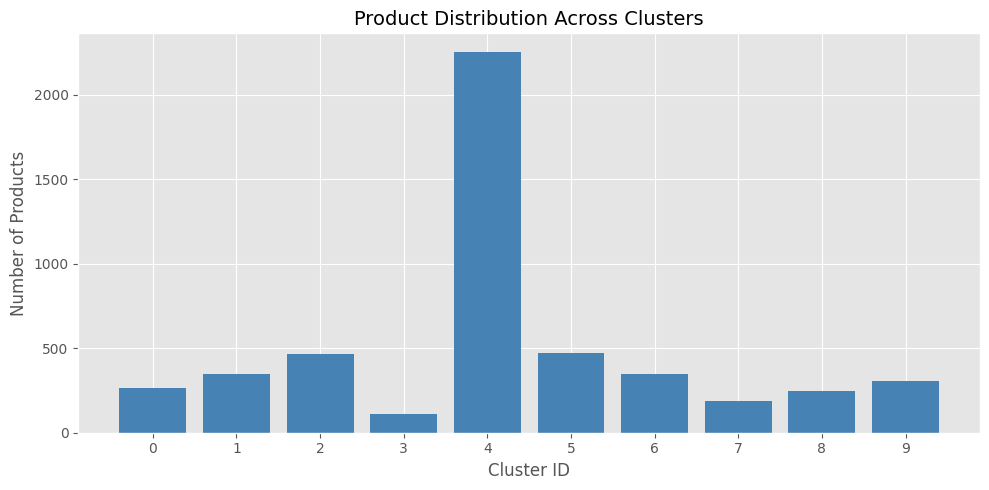

In [17]:
# Visualize cluster distribution
plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='steelblue')
plt.title('Product Distribution Across Clusters', fontsize=14)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.xticks(unique)
plt.tight_layout()
plt.show()

### Extract Cluster Descriptions (Top Terms)

In [18]:
# Get top terms per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# Create cluster descriptions
cluster_descriptions = {}

print("Top 10 terms per cluster:")
print("=" * 50)

for i in range(n_clusters):
    cluster_terms = [terms[ind] for ind in order_centroids[i, :15]]
    cluster_descriptions[i] = cluster_terms
    print(f"\nCluster {i}:")
    print(f"  {', '.join(cluster_terms[:10])}")

Top 10 terms per cluster:

Cluster 0:
  water, heater, hot, tank, valve, faucet, toilet, insulation, handle, watersense

Cluster 1:
  air, cooking, control, fan, heat, oven, ft, cycle, 000, power

Cluster 2:
  cabinet, storage, shelf, shelves, finish, vanity, easy, hardware, design, drawer

Cluster 3:
  tile, indoor, flooring, ceramic, installation, residential, commercial, recommended, wall, orders

Cluster 4:
  ft, use, easy, steel, resistant, used, water, construction, designed, metal

Cluster 5:
  wood, proposition, nbsp, residents, california, 65, post, ft, fence, used

Cluster 6:
  light, watt, bulb, led, lighting, bulbs, fixture, energy, white, glass

Cluster 7:
  paint, rug, patio, colors, outdoor, vary, dining, chairs, resistant, cushions

Cluster 8:
  battery, volt, power, lithium, tool, ion, speed, batteries, charger, driver

Cluster 9:
  door, doors, glass, steel, garage, security, panel, energy, hinges, installation


### Test Content-Based Recommendations

In [19]:
# Test: Get recommendations for a search query
def get_recommendations(query):
    """Get product recommendations based on search query"""
    Y = vectorizer.transform([query])
    prediction = kmeans.predict(Y)
    cluster_id = prediction[0]
    return cluster_id, cluster_descriptions[cluster_id]

# Test with different queries
test_queries = ["cutting tool", "water heater", "light bulb", "outdoor furniture"]

print("Testing Content-Based Recommendations:")
print("=" * 50)

for query in test_queries:
    cluster_id, terms = get_recommendations(query)
    print(f"\nQuery: '{query}'")
    print(f"  Cluster: {cluster_id}")
    print(f"  Related terms: {', '.join(terms[:8])}")

Testing Content-Based Recommendations:

Query: 'cutting tool'
  Cluster: 8
  Related terms: battery, volt, power, lithium, tool, ion, speed, batteries

Query: 'water heater'
  Cluster: 0
  Related terms: water, heater, hot, tank, valve, faucet, toilet, insulation

Query: 'light bulb'
  Cluster: 6
  Related terms: light, watt, bulb, led, lighting, bulbs, fixture, energy

Query: 'outdoor furniture'
  Cluster: 4
  Related terms: ft, use, easy, steel, resistant, used, water, construction


### Save Content-Based Model

In [20]:
# Save content-based filtering data
content_data = {
    'vectorizer': vectorizer,
    'kmeans_model': kmeans,
    'cluster_descriptions': cluster_descriptions,
    'n_clusters': n_clusters,
    'product_data': product_descriptions_subset[['product_uid', 'product_description']].reset_index(drop=True)
}

with open('models/content_based.pkl', 'wb') as f:
    pickle.dump(content_data, f)

print(f" Saved content-based model")
print(f"   Clusters: {n_clusters}")
print(f"   Products: {len(product_descriptions_subset):,}")
print(f"   File: models/content_based.pkl")

 Saved content-based model
   Clusters: 10
   Products: 5,000
   File: models/content_based.pkl


---
# Training Summary

All models have been trained and saved. The Streamlit app will load these pre-trained models.

In [21]:
# Display saved models
print("="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)
print("\nSaved Models:")

for f in os.listdir('models'):
    size = os.path.getsize(f'models/{f}') / (1024*1024)
    print(f"   {f}: {size:.2f} MB")

print("\n" + "="*60)
print("Next Step: Run the Streamlit app")
print("  Command: streamlit run app.py")
print("="*60)

MODEL TRAINING COMPLETE!

Saved Models:
   collaborative_filtering.pkl: 57.28 MB
   content_based.pkl: 4.85 MB
   popular_products.pkl: 6.90 MB

Next Step: Run the Streamlit app
  Command: streamlit run app.py
